In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
from sklearn.model_selection import train_test_split

In [125]:
data = pd.read_csv('diabetes_012_health_indicators_BRFSS2015.csv')

In [104]:
#less_data = data[:len(data)//10] #use only 10% of the data

In [126]:
#X = less_data.copy()
X = data.copy()
#Y = X.pop('Diabetes_012').values

In [127]:
print(X.shape)
X.head()

(253680, 22)


,Diabetes_012,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,5.0,18.0,15.0,1.0,0.0,9.0,4.0,3.0
1,0.0,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,3.0,0.0,0.0,0.0,0.0,7.0,6.0,1.0
2,0.0,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,5.0,30.0,30.0,1.0,0.0,9.0,4.0,8.0
3,0.0,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,11.0,3.0,6.0
4,0.0,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,2.0,3.0,0.0,0.0,0.0,11.0,5.0,4.0


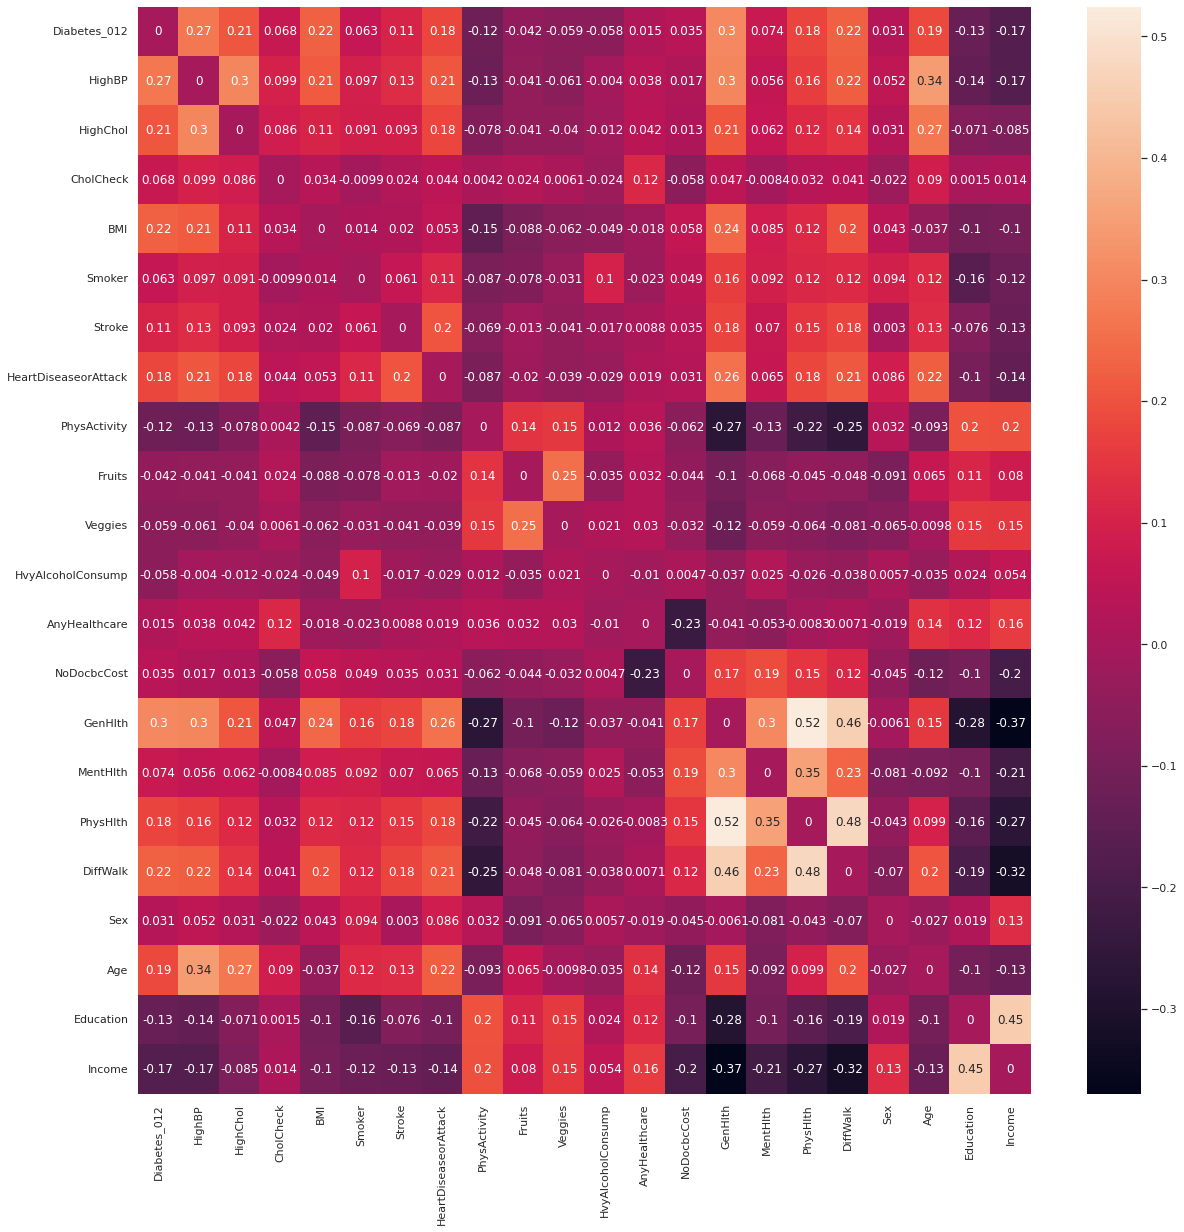

In [128]:
corr_mx = X.corr() # use pearson correlation coeff by default

for idx in range(corr_mx.shape[0]):
    corr_mx.iloc[idx, idx] = 0

sns.set(rc={'figure.figsize':(20,20)})
sns.heatmap(corr_mx, annot=True)
plt.show()

**Check for outliers**

In [129]:
from scipy import stats
# compute the Z-score for each entry from every feature and remove the datapoint if it is not within 3 std from the mean
X = data[(np.abs(stats.zscore(data)) < 3).all(axis=1)]
Y = X.pop('Diabetes_012')
print(X.shape)

(170236, 21)


**Check some skewed features**

{12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0}


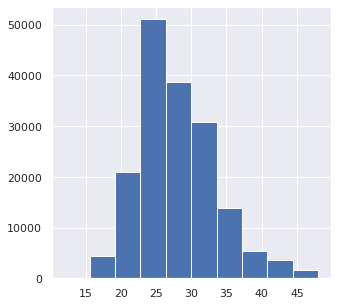

In [131]:
sns.set(rc={'figure.figsize':(5,5)})
X.BMI.hist()
print(set(X.BMI.values))

**Adjust skewed data**

In [ ]:
#skew =0(no skew) >0(right skew) <0(left skew)

#For right skewed data apply log(1+x)
log_columns = X.skew().sort_values(ascending=False)
log_columns = log_columns.loc[log_columns>0.75]
right_skewed = list(log_columns.index)
print(log_columns)

#applying log to features with high skew will result in more normally distributed data
for col in log_columns.index:
    X[col] = np.log1p(X[col])
    
print(X.skew().sort_values(ascending=False))    

In [133]:
#For left  skewed data apply x^3
left_skew = X.skew().sort_values(ascending=False)
left_skew = left_skew.loc[left_skew<-0.75]
#print(left_skew)
for col in left_skew.index:
    X[col] = X[col].pow(3)

#Data after adjusting the skewness   
print(X.skew().sort_values(ascending=False))    

DiffWalk                2.422646
MentHlth                1.844627
PhysHlth                1.613769
GenHlth                 0.467947
HighBP                  0.453309
Smoker                  0.438022
HighChol                0.426950
BMI                     0.295055
Sex                     0.273199
HeartDiseaseorAttack    0.000000
CholCheck               0.000000
Stroke                  0.000000
HvyAlcoholConsump       0.000000
AnyHealthcare           0.000000
NoDocbcCost             0.000000
Income                 -0.357473
Age                    -0.365007
Education              -0.614925
Fruits                 -0.663052
PhysActivity           -1.442748
Veggies                -1.730391
dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


**Scale data** (min-max scaler)

In [ ]:
from sklearn.preprocessing import MinMaxScaler
mm_scaler = MinMaxScaler()
for col in X.columns:
    X[col] = mm_scaler.fit_transform(X[[col]])

**PCA**

In [135]:
from sklearn.decomposition import PCA

pca_list = list()
feature_weight_list = list()

for n in range(1,21):
    #create and fit the model
    PCAmod = PCA(n_components = n)
    PCAmod.fit(X)
    
    #Store the model and variance
    pca_list.append(pd.Series({'n':n, 'model':PCAmod, 'var':PCAmod.explained_variance_ratio_.sum()}))
    
    #Calculate and store feature importances
    weights = PCAmod.explained_variance_ratio_.reshape(-1,1)/PCAmod.explained_variance_ratio_.sum() #add more weight to the most important PCs
    overall_contribution = np.abs(PCAmod.components_)*weights
    abs_feature_values = overall_contribution.sum(axis=0) # how every feature with their weightings comprise the PCs 
    feature_weight_list.append(pd.DataFrame({'n':n, 'features':X.columns, 'values':abs_feature_values/abs_feature_values.sum()}))

pca_df = pd.concat(pca_list, axis=1).T.set_index('n')
pca_df

,model,var
n,,
1,PCA(n_components=1),0.182385
2,PCA(n_components=2),0.313589
3,PCA(n_components=3),0.432391
4,PCA(n_components=4),0.539714
5,PCA(n_components=5),0.62793
6,PCA(n_components=6),0.703083
7,PCA(n_components=7),0.764127
8,PCA(n_components=8),0.821081
9,PCA(n_components=9),0.87155


In [136]:
from sklearn.decomposition import PCA

#chose the smallest number of components that explain at least 90% of variance
pca = PCA(n_components = 10)
pca.fit(X)

X_pca=pca.transform(X)

X_train, X_test, Y_train, Y_test = train_test_split( X_pca, Y, test_size=0.2, random_state=20)
print(X_train.shape)
print(X_test.shape)

(136188, 10)
(34048, 10)


**Grid search for hyperparam tuning**

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn import svm
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import classification_report

clf = svm.SVC(class_weight='balanced')
# defining parameter range
param_grid = {'C': [0.1],#, 1, 5, 10, 16],#, 100, 1000],
              'gamma': [0.1],#1, 0.1, 0.01, 0.001],# 0.0001],
              'kernel': ['poly', 'rbf', 'sigmoid','linear']}
 
grid = GridSearchCV(clf, param_grid, refit = True, verbose = 3)
 
# fitting the model for grid search
grid.fit(X_train, Y_train)

In [ ]:
# print best parameter after tuning
print(grid.best_params_)
 
# print how our model looks after hyper-parameter tuning
print(grid.best_estimator_)

{'C': 0.1, 'gamma': 0.1, 'kernel': 'poly'}
SVC(C=0.1, class_weight='balanced', gamma=0.1, kernel='poly')


In [111]:
from sklearn import svm
clf = svm.SVC(C=0.1, kernel = 'poly', gamma = 0.1,class_weight='balanced')
clf.fit(X_train, Y_train)
prediction = clf.predict(X_test)

**Results**

In [137]:
from sklearn.metrics import classification_report
from sklearn.metrics import mean_absolute_error as mae
labels=['0','1','2']
print(classification_report(Y_test, prediction, target_names=labels))
print("MAE: ",mae(Y_test,prediction))

from sklearn.metrics import matthews_corrcoef,f1_score,accuracy_score
svm_train_mcc = matthews_corrcoef(Y_test, prediction)
svm_train_accuracy = accuracy_score(Y_test, prediction)
svm_train_f1_score=f1_score(Y_test, prediction,average='weighted')
print("F1-Score: ",svm_train_f1_score*100)
print("Accuracy Score: ",svm_train_accuracy*100)
print("MCC: ",svm_train_mcc*100)

              precision    recall  f1-score   support

           0       0.93      0.76      0.84     29580
           1       0.03      0.39      0.05       537
           2       0.35      0.23      0.27      3931

    accuracy                           0.69     34048
   macro avg       0.44      0.46      0.39     34048
weighted avg       0.85      0.69      0.76     34048

MAE:  0.3972626879699248
F1-Score:  75.84782763449655
Accuracy Score:  69.2375469924812
MCC:  19.46912970619674
